In [1]:
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential 
from keras.layers import Dense, LSTM  # importing layers package , Dense layer is used to connect all layers
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') 

In [2]:
dataset5 = web.DataReader('HINDUNILVR.NS', data_source='yahoo',start='2015-08-30',end='2022-10-06')
dataset5

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-08-31,870.000000,848.799988,862.900024,860.900024,1990625.0,765.650085
2015-09-01,861.349976,848.349976,855.000000,853.750000,1483369.0,759.291077
2015-09-02,862.400024,824.200012,857.000000,830.599976,1463479.0,738.702454
2015-09-03,841.750000,815.099976,830.500000,833.750000,1228866.0,741.503845
2015-09-04,840.750000,823.200012,831.349976,830.000000,1332041.0,738.168823
...,...,...,...,...,...,...
2022-09-29,2727.000000,2691.100098,2711.100098,2700.550049,2019666.0,2700.550049
2022-09-30,2714.899902,2667.899902,2707.000000,2696.449951,1340054.0,2696.449951
2022-10-03,2734.000000,2617.550049,2723.000000,2622.500000,1683197.0,2622.500000


In [5]:
len(dataset5)

1752

In [6]:
dataset5.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2022-09-29,2727.000000,2691.100098,2711.100098,2700.550049,2019666.0,2700.550049
2022-09-30,2714.899902,2667.899902,2707.000000,2696.449951,1340054.0,2696.449951
2022-10-03,2734.000000,2617.550049,2723.000000,2622.500000,1683197.0,2622.500000
2022-10-04,2676.500000,2634.149902,2650.000000,2667.949951,1327939.0,2667.949951
2022-10-06,2692.300049,2605.050049,2681.300049,2614.000000,1752088.0,2614.000000


In [7]:
opn=dataset5[['Open']]

<AxesSubplot:xlabel='Date'>

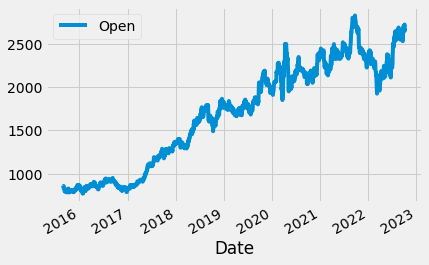

In [8]:
opn.plot()

In [9]:
ds=opn.values

In [10]:
ds

array([[ 862.90002441],
       [ 855.        ],
       [ 857.        ],
       ...,
       [2723.        ],
       [2650.        ],
       [2681.30004883]])

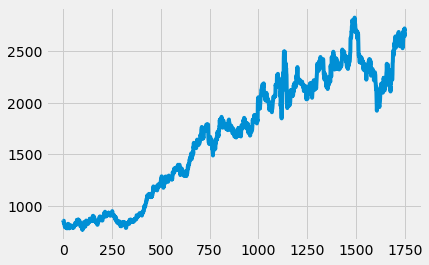

In [11]:
plt.plot(ds)

In [12]:
normalizer=MinMaxScaler(feature_range=(0,1))
ds_scaled=normalizer.fit_transform(np.array(ds).reshape(-1,1))

In [13]:
len(ds_scaled),len(ds)

(1752, 1752)

In [14]:
train_size=int(len(ds_scaled)*0.70)
test_size=len(ds_scaled)-train_size

In [15]:
train_size,test_size

(1226, 526)

In [16]:
ds_train,ds_test=ds_scaled[0:train_size,:],ds_scaled[train_size:len(ds_scaled),:1]

In [17]:
len(ds_train),len(ds_test)

(1226, 526)

In [18]:
#creating dataset in time series for LSTM model 
#X[100,120,140,160,180] : Y[200]
def create_ds(dataset,step):
    Xtrain, Ytrain = [], []
    for i in range(len(dataset)-step-1):
        a = dataset[i:(i+step), 0]
        Xtrain.append(a)
        Ytrain.append(dataset[i + step, 0])
    return np.array(Xtrain), np.array(Ytrain)

In [19]:
#Taking 100 days price as one record for training
time_stamp = 100
X_train, y_train = create_ds(ds_train,time_stamp)
X_test, y_test = create_ds(ds_test,time_stamp)

In [20]:
X_train.shape,y_train.shape

((1125, 100), (1125,))

In [21]:
X_test.shape, y_test.shape

((425, 100), (425,))

In [22]:
#Reshaping data to fit into LSTM model
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [23]:
#Creating LSTM model using keras
model = Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(X_train.shape[1],1)))
model.add(LSTM(units=50,return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(units=1,activation='linear'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [24]:
#Training model with adam optimizer and mean squared error loss function
model.compile(loss='mean_squared_error',optimizer='adam')
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=90)

Epoch 1/100
13/13 [==============================] - 11s 346ms/step - loss: 0.0528 - val_loss: 0.0505
Epoch 2/100
13/13 [==============================] - 3s 220ms/step - loss: 0.0076 - val_loss: 0.0031
Epoch 3/100
13/13 [==============================] - 3s 225ms/step - loss: 0.0020 - val_loss: 0.0028
Epoch 4/100
13/13 [==============================] - 3s 208ms/step - loss: 0.0013 - val_loss: 0.0027
Epoch 5/100
13/13 [==============================] - 3s 218ms/step - loss: 0.0011 - val_loss: 0.0034
Epoch 6/100
13/13 [==============================] - 3s 209ms/step - loss: 0.0011 - val_loss: 0.0037
Epoch 7/100
13/13 [==============================] - 3s 209ms/step - loss: 0.0011 - val_loss: 0.0031
Epoch 8/100
13/13 [==============================] - 3s 227ms/step - loss: 0.0011 - val_loss: 0.0031
Epoch 9/100
13/13 [==============================] - 3s 220ms/step - loss: 0.0010 - val_loss: 0.0030
Epoch 10/100
13/13 [==============================] - 3s 219ms/step - loss: 0.0010 - val_l

13/13 [==============================] - 3s 224ms/step - loss: 3.5594e-04 - val_loss: 9.3784e-04
Epoch 79/100
13/13 [==============================] - 3s 197ms/step - loss: 3.6959e-04 - val_loss: 0.0015
Epoch 80/100
13/13 [==============================] - 3s 198ms/step - loss: 3.5177e-04 - val_loss: 8.9111e-04
Epoch 81/100
13/13 [==============================] - 3s 209ms/step - loss: 3.4509e-04 - val_loss: 0.0013
Epoch 82/100
13/13 [==============================] - 3s 205ms/step - loss: 3.6868e-04 - val_loss: 0.0031
Epoch 83/100
13/13 [==============================] - 3s 209ms/step - loss: 4.7048e-04 - val_loss: 0.0013
Epoch 84/100
13/13 [==============================] - 3s 217ms/step - loss: 4.0930e-04 - val_loss: 9.0847e-04
Epoch 85/100
13/13 [==============================] - 3s 206ms/step - loss: 3.8830e-04 - val_loss: 0.0012
Epoch 86/100
13/13 [==============================] - 3s 198ms/step - loss: 3.6998e-04 - val_loss: 8.5790e-04
Epoch 87/100
13/13 [=======================

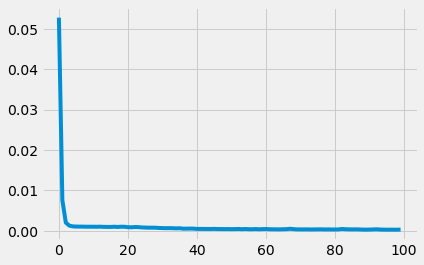

In [25]:
#PLotting loss, it shows that loss has decreased significantly and model trained well
loss = model.history.history['loss']
plt.plot(loss)

In [26]:
#Predicitng on train and test data
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

In [27]:
#Inverse transform to get actual value
train_predict = normalizer.inverse_transform(train_predict)
test_predict = normalizer.inverse_transform(test_predict)

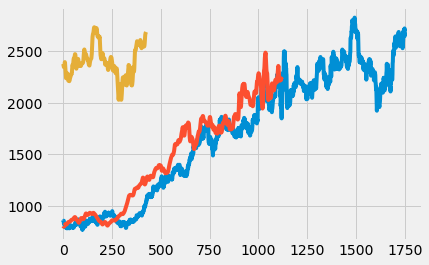

In [28]:
#Comparing using visuals
plt.plot(normalizer.inverse_transform(ds_scaled),label= 'Scaled Value')
plt.plot((train_predict),label= 'Training value')
plt.plot((test_predict),label= 'Testing value')

In [29]:
type(train_predict)

numpy.ndarray

In [30]:
test = np.vstack((train_predict,test_predict))

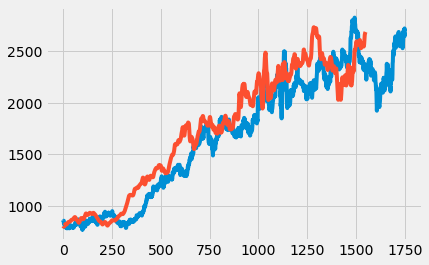

In [31]:
#Combining the predited data to create uniform data visualization
plt.plot(normalizer.inverse_transform(ds_scaled))
plt.plot(test)

In [32]:
len(ds_test)

526

In [33]:
#Getting the last 100 days records
fut_inp = ds_test[426:]

In [34]:
fut_inp = fut_inp.reshape(1,-1)

In [35]:
tmp_inp = list(fut_inp)

In [36]:
fut_inp.shape

(1, 100)

In [37]:
#Creating list of the last 100 data
tmp_inp = tmp_inp[0].tolist()

In [38]:
#Predicting next 30 days price suing the current data
#It will predict in sliding window manner (algorithm) with stride 1
lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(tmp_inp)>100):
        fut_inp = np.array(tmp_inp[1:])
        fut_inp=fut_inp.reshape(1,-1)
        fut_inp = fut_inp.reshape((1, n_steps, 1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        tmp_inp = tmp_inp[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        fut_inp = fut_inp.reshape((1, n_steps,1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[[0.9198936820030212], [0.9125357270240784], [0.9049956798553467], [0.8975222110748291], [0.8903400301933289], [0.8836632966995239], [0.8776772022247314], [0.87252277135849], [0.8682960271835327], [0.8650382161140442], [0.8627431392669678], [0.861365020275116], [0.8608261942863464], [0.8610228896141052], [0.861834704875946], [0.8631289601325989], [0.8647711873054504], [0.8666306138038635], [0.8685852289199829], [0.8705251812934875], [0.8723581433296204], [0.8740076422691345], [0.8754184246063232], [0.8765528798103333], [0.8773916363716125], [0.8779299259185791], [0.8781790733337402], [0.8781586289405823], [0.877900242805481], [0.8774397373199463]]


In [39]:
len(ds_scaled)

1752

In [41]:
#Creating a dummy plane to plot graph one after another
plot_new=np.arange(1,101)
plot_pred=np.arange(101,131)

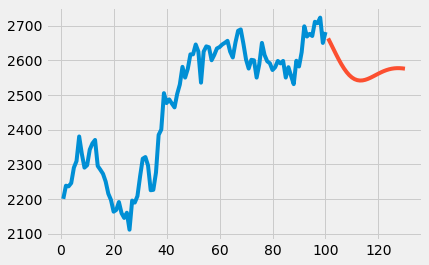

In [42]:
plt.plot(plot_new, normalizer.inverse_transform(ds_scaled[1652:]))
plt.plot(plot_pred, normalizer.inverse_transform(lst_output))

In [43]:
ds_new = ds_scaled.tolist()

In [44]:
len(ds_new)

1752

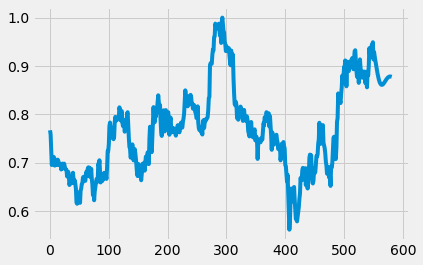

In [45]:
#Entends helps us to fill the missing value with approx value
ds_new.extend(lst_output)
plt.plot(ds_new[1200:])

In [46]:
#Creating final data for plotting
final_graph = normalizer.inverse_transform(ds_new).tolist()

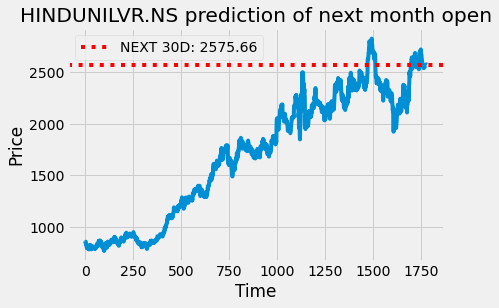

In [47]:
#Plotting final results with predicted value after 30 Days
plt.plot(final_graph,)
plt.ylabel("Price")
plt.xlabel("Time")
plt.title("{0} prediction of next month open".format('HINDUNILVR.NS'))
plt.axhline(y=final_graph[len(final_graph)-1], color = 'red', linestyle = ':', label = 'NEXT 30D: {0}'.format(round(float(*final_graph[len(final_graph)-1]),2)))
plt.legend()

In [70]:
for i in range(0,len(final_graph)):
    print(final_graph[i])


[862.9000244140625]
[855.0]
[857.0]
[830.5]
[831.3499755859375]
[831.0]
[827.7999877929688]
[806.0]
[801.0]
[792.0]
[800.9000244140625]
[794.75]
[811.0]
[807.0]
[795.0]
[792.0]
[788.7999877929688]
[789.0]
[785.0]
[782.5999755859375]
[799.7999877929688]
[817.7999877929688]
[820.5499877929688]
[816.9500122070312]
[818.0]
[827.0]
[826.0]
[819.0]
[817.0]
[814.0499877929688]
[783.0]
[788.0]
[784.9000244140625]
[797.4500122070312]
[788.0]
[795.0]
[802.7999877929688]
[806.75]
[811.5999755859375]
[811.0]
[802.0]
[799.25]
[805.0]
[806.7999877929688]
[801.0]
[806.7000122070312]
[794.0]
[802.0]
[792.3499755859375]
[794.0]
[785.9000244140625]
[798.0]
[797.5]
[799.8499755859375]
[795.0499877929688]
[794.0]
[814.7000122070312]
[812.5]
[813.5]
[811.8499755859375]
[832.9000244140625]
[827.8499755859375]
[813.3499755859375]
[815.0]
[831.9000244140625]
[827.0]
[823.0]
[818.2999877929688]
[825.0]
[839.2000122070312]
[865.0]
[840.0]
[865.5999755859375]
[861.9500122070312]
[852.9500122070312]
[859.45001220

[2197.0]
[2220.35009765625]
[2170.0]
[2125.800048828125]
[2135.0]
[2140.0]
[2132.0]
[2162.0]
[2140.0]
[2167.0]
[2159.0]
[2145.0]
[2153.0]
[2141.0]
[2189.25]
[2259.5]
[2260.0]
[2290.0]
[2366.25]
[2380.949951171875]
[2361.0]
[2317.10009765625]
[2342.0]
[2322.0]
[2343.0]
[2310.0]
[2320.0]
[2382.5]
[2405.0]
[2395.0]
[2390.0]
[2396.0]
[2395.39990234375]
[2405.0]
[2405.0]
[2445.800048828125]
[2432.0]
[2390.0]
[2425.0]
[2429.800048828125]
[2381.89990234375]
[2366.0]
[2392.5]
[2374.5]
[2342.0]
[2357.0]
[2376.0]
[2359.0]
[2420.0]
[2425.0]
[2367.89990234375]
[2315.10009765625]
[2276.64990234375]
[2271.050048828125]
[2231.5]
[2239.0]
[2245.60009765625]
[2288.0]
[2247.0]
[2220.0]
[2242.0]
[2268.0]
[2251.0]
[2227.0]
[2196.0]
[2164.0]
[2152.89990234375]
[2205.0]
[2185.0]
[2188.5]
[2177.0]
[2158.0]
[2135.199951171875]
[2162.0]
[2205.0]
[2185.0]
[2184.60009765625]
[2210.0]
[2176.0]
[2210.5]
[2236.0]
[2206.10009765625]
[2221.35009765625]
[2254.0]
[2238.0]
[2204.10009765625]
[2310.10009765625]
[2363.0]


In [71]:
writer=pd.ExcelWriter('HindustanUni_Sept.xlsx')

In [72]:
data1=pd.DataFrame({'Predictions':final_graph})

In [73]:
data1.to_excel(writer)

In [74]:
writer.save()